Classification Report:
              precision    recall  f1-score   support

     NATURAL       0.94      0.90      0.92       629
      DROWSY       0.89      0.93      0.91       543

    accuracy                           0.92      1172
   macro avg       0.92      0.92      0.92      1172
weighted avg       0.92      0.92      0.92      1172



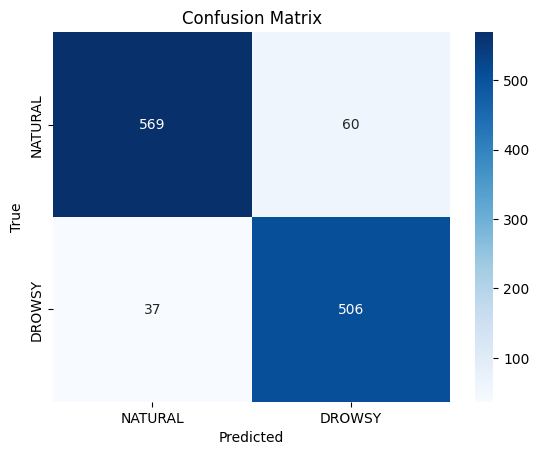

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Path dataset
train_dir = 'train'
categories = ['NATURAL', 'DROWSY']

# Ukuran gambar yang seragam
IMG_SIZE = (64, 64)

# Load gambar dan label
data = []
labels = []

for idx, category in enumerate(categories):
    path = os.path.join(train_dir, category)
    if not os.path.exists(path):
        print(f"Folder {category} tidak ditemukan!")
        continue
    
    for file in os.listdir(path):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            try:
                img_path = os.path.join(path, file)
                img = Image.open(img_path).convert("L")  # Grayscale
                img = img.resize(IMG_SIZE)
                img_array = np.array(img).flatten()  # Flatten ke 1D
                data.append(img_array)
                labels.append(idx)  # 0 untuk NATURAL, 1 untuk DROWSY
            except Exception as e:
                print(f"Gagal memproses {file}: {e}")

# Convert ke array numpy
X = np.array(data)
y = np.array(labels)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model SVM
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)

# Prediksi
y_pred = svm_model.predict(X_test)

# Evaluasi
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=categories))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=categories, yticklabels=categories, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


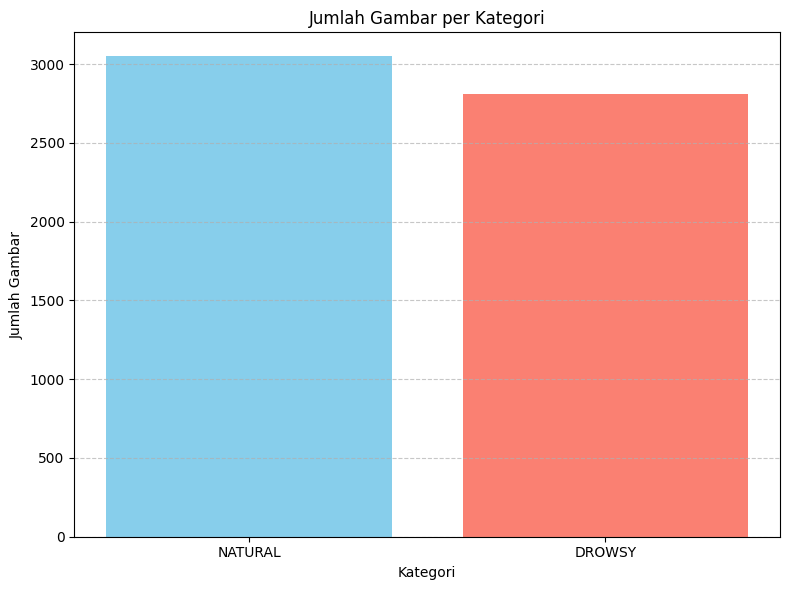

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Path dataset
train_dir = 'train'
categories = ['NATURAL', 'DROWSY']

# Ukuran gambar yang seragam
IMG_SIZE = (64, 64)

# Load gambar dan label
data = []
labels = []

# Untuk menyimpan jumlah gambar per kategori
image_counts = {}

for idx, category in enumerate(categories):
    path = os.path.join(train_dir, category)
    if not os.path.exists(path):
        print(f"Folder {category} tidak ditemukan!")
        image_counts[category] = 0
        continue
    
    count = 0
    for file in os.listdir(path):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            try:
                img_path = os.path.join(path, file)
                img = Image.open(img_path).convert("L")  # Grayscale
                img = img.resize(IMG_SIZE)
                img_array = np.array(img).flatten()  # Flatten ke 1D
                data.append(img_array)
                labels.append(idx)  # 0 untuk NATURAL, 1 untuk DROWSY
                count += 1
            except Exception as e:
                print(f"Gagal memproses {file}: {e}")
    image_counts[category] = count

# Tampilkan jumlah gambar per kategori dalam bentuk barchart
plt.figure(figsize=(8, 6))
plt.bar(image_counts.keys(), image_counts.values(), color=['skyblue', 'salmon'])
plt.title("Jumlah Gambar per Kategori")
plt.xlabel("Kategori")
plt.ylabel("Jumlah Gambar")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [4]:
import joblib
import h5py
import numpy as np

# Simpan model SVM ke file pickle
joblib.dump(svm_model, 'svm_model.pkl')

# Konversi file pickle ke .h5
with h5py.File('svm_model.h5', 'w') as h5f:
    with open('svm_model.pkl', 'rb') as pkl_file:
        model_bytes = pkl_file.read()
        h5f.create_dataset('svm_model', data=np.void(model_bytes))

print("Model SVM berhasil disimpan dalam format .h5")


Model SVM berhasil disimpan dalam format .h5


In [5]:
# Load model SVM dari .h5
with h5py.File('svm_model.h5', 'r') as h5f:
    model_bytes = h5f['svm_model'][()]
    with open('temp_model.pkl', 'wb') as temp_file:
        temp_file.write(model_bytes.tobytes())

# Load model dari file .pkl
svm_model_loaded = joblib.load('temp_model.pkl')

# Coba prediksi lagi dengan model yang dimuat ulang
y_pred_loaded = svm_model_loaded.predict(X_test)


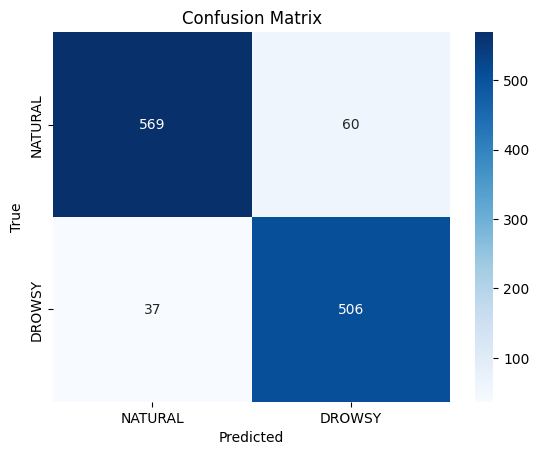

In [6]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_loaded)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=categories, yticklabels=categories, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [1]:
import cv2
import numpy as np
import h5py
import joblib
from PIL import Image

# Load model SVM dari file .h5 (hasil konversi sebelumnya)
with h5py.File('svm_model.h5', 'r') as h5f:
    model_bytes = h5f['svm_model'][()]
    with open('temp_model.pkl', 'wb') as temp_file:
        temp_file.write(model_bytes.tobytes())

svm_model = joblib.load('temp_model.pkl')

# Mapping label kelas (misal: 0 = NATURAL, 1 = DROWSY)
class_labels = {0: 'NATURAL', 1: 'DROWSY'}

# Inisialisasi Webcam
cap = cv2.VideoCapture(0)

IMG_SIZE = (64, 64)  # Ukuran gambar sesuai pelatihan SVM

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Konversi frame ke grayscale dan resize
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, IMG_SIZE)

    # Flatten (ubah ke 1D array)
    img_array = resized.flatten().reshape(1, -1)

    # Prediksi dengan model SVM
    prediction = svm_model.predict(img_array)
    class_label = class_labels[prediction[0]]

    # Tentukan warna berdasarkan label
    color = (0, 255, 0) if class_label == 'NATURAL' else (0, 0, 255)

    # Tampilkan teks dengan warna yang sesuai
    cv2.putText(frame, f"Prediksi: {class_label}", (10, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)


    # Tampilkan frame
    cv2.imshow("Webcam Prediction", frame)

    # Tekan 'q' untuk keluar
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Bersihkan
cap.release()
cv2.destroyAllWindows()
